In [6]:
import h5py
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import joblib
import os


f_train = h5py.File("data/raw/X_train.h5/X_train.h5","r")
f_test = h5py.File("data/raw/X_test.h5/X_test.h5","r")


y_train_raw = pd.read_csv('data/raw/y_train.csv')



In [25]:
def windows_split(X_data):
    """split the data in windows of length n for manipulation such as MMD (ref entropy.pdf figure 7"""
    n = len(X_data)
    return np.array([X_data[i*100:100*(i+1)] for i in range(n//100)])

def MMD(data_array):
    """return MMD of a signal"""
    n_pts = len(data_array)
    min_val = data_array[0]
    max_val = data_array[0]
    min_index = 0
    max_index = 0
    for i in range(n_pts):
        if data_array[i]<min_val:
            min_val = data_array[min_index]
            min_index = i
        if data_array[i]>max_val:
            max_val = data_array[max_index]
            min_index = i
        
    d = np.sqrt((max_index-min_index)**2 + (max_val-min_val)**2)
    return d


def MMD_epoch(data_epoch):
    """return sum of the MMD of each window of an epoch"""
    return sum([MMD(split) for split in windows_split(data_epoch)])

def get_mid_freq(freq_seq):
    """get the frequence where the amplitude of the integral at left and right are equal"""
    n_pts = len(freq_seq)
    integral = np.sum(np.abs(freq_seq[:n_pts//2]))
    cum_sum = 0 
    for i in range(len(freq_seq)):
        cum_sum = cum_sum + np.abs(freq_seq[i])
        if cum_sum>=integral/2:
            # print(cum_sum,integral)
            return i

def get_amplitude_range_freq(freq_seq,fmin,fmax):
    """get the sum of amplitude of frequencies in a given range"""
    return np.sum(np.abs(freq_seq[fmin:fmax]))
    



def esis(data_array):
    """retur sum of amplitude of the signal"""
    return np.sum(np.square(np.abs(data_array)))

def esis_epoch(data_epoch):
    """return sum of amplitude of the signal for an epoch"""
    return sum([esis(split) for split in windows_split(data_epoch)])



def get_features(data,n=None):
    """extract de features from the data""" 
    n_eeg = 2
    
    if n !=None: #take only part of the data
        data_cut = {}
        for key in data.keys():
            data_cut[key] = data[key][:n]
        data = data_cut
    feature_dic={}
    for i in range(1,n_eeg+1) : feature_dic['eeg_' +str(i)+"MMD"] = [MMD_epoch(eeg_epoch) for eeg_epoch in data['eeg_' +str(i)][:]]
    feature_dic["xMMD"] = [MMD_epoch(pos_epoch) for pos_epoch in data['x'][:]]
    feature_dic["yMMD"] = [MMD_epoch(pos_epoch) for pos_epoch in data['y'][:]]
    feature_dic["zMMD"] = [MMD_epoch(pos_epoch) for pos_epoch in data['z'][:]]
    feature_dic["pulseMMD"] = [MMD_epoch(pos_epoch) for pos_epoch in data['pulse'][:]]

    for i in range(1,n_eeg+1) : feature_dic["eeg_"+str(i)+"esis"] = [esis_epoch(eeg_epoch) for eeg_epoch in data['eeg_'+str(i)][:]]
    feature_dic["xesis"] = [esis_epoch(pos_epoch) for pos_epoch in data['x'][:]]
    feature_dic["yesis"] = [esis_epoch(pos_epoch) for pos_epoch in data['y'][:]]
    feature_dic["zesis"] = [esis_epoch(pos_epoch) for pos_epoch in data['z'][:]]
    feature_dic["pulseesis"] = [esis_epoch(pos_epoch) for pos_epoch in data['pulse'][:]]

    for i in range(1,n_eeg+1): feature_dic["eeg_"+str(i)+"midfreq"] = [get_mid_freq(eeg_epoch) for eeg_epoch in data['eeg_'+str(i)][:]]
    
    
    return pd.DataFrame(feature_dic)

In [26]:
n_pts = 1000
X_features=get_features(f_train,n_pts)

y_train_vals = y_train_raw["sleep_stage"][:n_pts].values

# on passe l'output en chaine de caracteres 
y_train_vals = [str(y) for y in y_train_vals]

In [29]:
####### save load ######
import joblib 

joblib.dump(X_features,"data/processed/X_features_last")
joblib.dump(y_train_vals,"data/processed/y_last")

# X_features = joblib.load("data/processed/X_train_last")
# y_train_vals = joblib.load("data/processed/y_last")

['data/processed/y_last']

In [32]:
#ML PART
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import joblib

X=X_features
y=y_train_vals

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#chose model
model = RandomForestClassifier()

#split train/test
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.33,random_state =42)

#train
model.fit(x_train,y_train)

#evaluation
sc = model.score(x_test,y_test), model.score(x_train,y_train)

print(sc)

(0.693939393939394, 1.0)


In [17]:
#############################
#TEST BELLOW
#############################

In [55]:
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())


2    217
3    214
0    116
4     91
1     32
dtype: int64
3    116
2    100
0     59
4     46
1      9
dtype: int64


In [18]:
model.feature_importances_

array([0.08452545, 0.06105623, 0.03019909, 0.03342857, 0.03079366,
       0.05190573, 0.12391937, 0.06005587, 0.08962705, 0.12564596,
       0.17736885, 0.05532163, 0.0394663 , 0.03668623])

In [2]:
#describe data
# print(len(f_test["eeg_1"]))
print(f_train.keys())
print(len(f_train["eeg_1"]))

# print(f_test["index"][10:])
print(f_train["index_window"][1020:1030])
print(f_train["index_absolute"][1020:1030])
print(f_train["index"][1020:1030])



<KeysViewHDF5 ['eeg_1', 'eeg_2', 'eeg_3', 'eeg_4', 'eeg_5', 'eeg_6', 'eeg_7', 'index', 'index_absolute', 'index_window', 'pulse', 'x', 'y', 'z']>
24688
[1020 1021 1022 1023 1024 1025 1026    0    1    2]
[1020 1021 1022 1023 1024 1025 1026 1027 1028 1029]
[0 0 0 0 0 0 0 1 1 1]


In [16]:

eeg1_merged = np.array(f_train["eeg_1"][:100]).reshape(-1)
eeg7_merged = np.array(f_train["eeg_1"][:100]).reshape(-1)
x_merged = np.array(f_train["x"][:100]).reshape(-1)


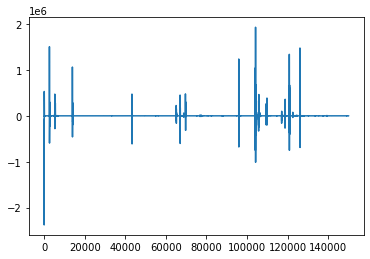

In [30]:

plt.plot(eeg7_merged[:])
# plt.plot(f_train["eeg_7"][5])

In [7]:
fft_sig = np.fft.fft(test)
delta = get_amplitude_range_freq(fft_sig,0,4)
theta = get_amplitude_range_freq(fft_sig,4,8)
alpha = get_amplitude_range_freq(fft_sig,8,13)
beta = get_amplitude_range_freq(fft_sig,13,22)
gamma = get_amplitude_range_freq(fft_sig,30,len(fft_sig)//2)


2    4787
3    2466
4    2395
0    1855
1     841
dtype: int64
2    4662
3    2758
4    2438
0    1656
1     830
dtype: int64


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


n_test = 500
model = RandomForestClassifier()

x_train,x_test,y_train,y_test = train_test_split(X_scaled,y_train_vals,test_size=0.33,random_state =42)

model.fit(x_train,y_train)

sc = model.score(x_test,y_test), model.score(x_train,y_train)

print(sc)

print(confusion_matrix(y_test,model.predict(x_test)))


(0.6407707412862053, 1.0)
[[ 810    7  221   75   55]
 [ 113   17  284   32  105]
 [ 122    6 2419  321  221]
 [  69    0  449 1229    4]
 [ 108    6  660   69  746]]


In [12]:
import joblib
x_train,y_train = X_scaled,y_train_vals
model.fit(x_train,y_train)
joblib.dump(model,"models/model1.save")
joblib.dump(x_train,"models/x_train1")
joblib.dump(y_train,"models/y_train1")
joblib.dump(scaler,"models/scaler1")

['models/model1.save']

In [38]:
a=[1,2,3,4,5,6]
print(a[:len(a)-2],a[-2:])

[1, 2, 3, 4] [5, 6]


In [38]:
model.feature_importances_

array([0.11465078, 0.08531366, 0.06131762, 0.03028399, 0.03918723,
       0.03281094, 0.05667189, 0.13134883, 0.08692176, 0.12304804,
       0.01548761, 0.01601414, 0.00261581, 0.08276893, 0.04207947,
       0.03910209, 0.0403772 ])

In [41]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_features=2)

n_train = 4000

model.fit(X[:n-n_train],y_train_vals[:n-n_train])

model.score(X[-n_train:],y_train_vals[-n_train:]), model.score(X[:n-n_train],y_train_vals[:n-n_train])


(0.29375, 1.0)

In [28]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_scaled[:800],y_train_vals[:800],)

model.score(X_scaled[801:1000],y_train_vals[801:1000]), model.score(X_scaled[:800],y_train_vals[:800])

# f1_score(y_pred,y_train_vals[801:1000])

(0.08040201005025126, 1.0)

In [24]:
import seaborn as sns
sns.pairplot(X)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "C:\Users\admin\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-10802b88b195>", line 2, in <module>
    sns.pairplot(X)
  File "C:\Users\admin\anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py", line 46, in inner_f
    return f(**kwargs)
  File "C:\Users\admin\anaconda3\envs\myenv\lib\site-packages\seaborn\axisgrid.py", line 1961, in pairplot
    grid.map_diag(histplot, **diag_kws)
  File "C:\Users\admin\anaconda3\envs\myenv\lib\site-packages\seaborn\axisgrid.py", line 1377, in map_diag
    func(x=vector, **plot_kwargs)
  File "C:\Users\admin\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py", line 1435, in histplot
    **kwargs,
  File "C:\Users\admin\anaconda3\envs\myenv\lib\site-packag

TypeError: object of type 'NoneType' has no len()

In [28]:
X.corr


<bound method DataFrame.corr of                0            1             2            3             4   \
0     3946.040978  8366.213684  38711.394373  1859.543999  39787.368942   
1     2057.841920  5516.009115   1511.849566  1730.004264   1991.008987   
2     2359.579686  5338.158121   1639.104670  1717.202066   2298.976889   
3     2560.093541  4898.809954   1558.366382  1532.529384   2498.687731   
4     1744.753880  1727.261782   1511.405197  1559.519972   1699.589671   
...           ...          ...           ...          ...           ...   
1995  1594.887702  1493.124914   1480.344480  1426.682135   1621.383630   
1996  1576.717466  1495.246838   1407.017598  1481.922378   1591.587749   
1997  1574.652794  1485.669884   1468.010398  1462.945724   1565.615529   
1998  1511.963323  1469.346976   1437.793064  1442.165400   1537.898453   
1999  1494.634370  1562.456667   1425.702901  1460.828225   1477.981241   

                5             6           7           8           9